In [1]:
import numpy as np
import pandas as pd

In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print (str(n_users) + 'users')
print (str(n_items) + 'items')

943users
1682items


构造 用户-电影评分矩阵


In [4]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

计算数据稀疏度


In [5]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


　把每个用户对电影的10个评分拿出来，将数据分为训练集与测试机两部分


In [6]:
from sklearn import cross_validation as cv
train_data, test_data = cv.train_test_split(ratings, test_size=0.25)

/usr/local/src/anaconda3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = 1 - pairwise_distances(train_data, metric='cosine')
item_similarity = 1 - pairwise_distances(train_data.T, metric='cosine')

In [10]:
# %timeit fast_similarity(train, kind='user')

In [11]:
user_similarity

array([[ 1.        ,  0.26130103,  0.10155556, ...,  0.10177687,
         0.20632874,  0.01614374],
       [ 0.26130103,  1.        ,  0.20334048, ...,  0.39746043,
         0.08489108,  0.17076797],
       [ 0.10155556,  0.20334048,  1.        , ...,  0.14033345,
         0.16100994,  0.13771685],
       ..., 
       [ 0.10177687,  0.39746043,  0.14033345, ...,  1.        ,
         0.0816787 ,  0.15970535],
       [ 0.20632874,  0.08489108,  0.16100994, ...,  0.0816787 ,
         1.        ,  0.00403069],
       [ 0.01614374,  0.17076797,  0.13771685, ...,  0.15970535,
         0.00403069,  1.        ]])

In [12]:
item_similarity

array([[ 1.        ,  0.40939854,  0.30484917, ...,  0.        ,
         0.055279  ,  0.055279  ],
       [ 0.40939854,  1.        ,  0.26904419, ...,  0.        ,
         0.09124486,  0.09124486],
       [ 0.30484917,  0.26904419,  1.        , ...,  0.        ,
         0.        ,  0.11103498],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.055279  ,  0.09124486,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.055279  ,  0.09124486,  0.11103498, ...,  0.        ,
         0.        ,  1.        ]])

In [13]:
# def predict_fast_simple(ratings, similarity, kind='user'):
#     if kind == 'user':
#         return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
#     elif kind == 'item':
#         return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [21]:
def predict(ratings, similarity, types):
    if types == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif types == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])    
    return pred

In [22]:
item_prediction = predict(train_data, item_similarity, types = 'item')
user_prediction = predict(train_data, user_similarity, types = 'user')

In [23]:
for i in range(item_prediction.shape[0]):
    for j in range(item_prediction.shape[1]):
        if item_prediction[i][j] > max(item_prediction[i]) * 0.8:
            print ("user:%s , film:%s , max_ranting:%f" %(i,j,item_prediction[i][j]))

user:0 , film:1617 , max_ranting:0.318784
user:0 , film:1653 , max_ranting:0.387808
user:1 , film:1617 , max_ranting:1.114325
user:1 , film:1626 , max_ranting:0.954980
user:1 , film:1653 , max_ranting:0.921805
user:1 , film:1673 , max_ranting:0.893306
user:2 , film:710 , max_ranting:0.417437
user:2 , film:1419 , max_ranting:0.513273
user:3 , film:1234 , max_ranting:0.694759
user:3 , film:1235 , max_ranting:0.694759
user:3 , film:1430 , max_ranting:0.576052
user:3 , film:1652 , max_ranting:0.570464
user:3 , film:1677 , max_ranting:0.615252
user:3 , film:1678 , max_ranting:0.615252
user:3 , film:1679 , max_ranting:0.615252
user:4 , film:114 , max_ranting:0.986677
user:4 , film:1298 , max_ranting:0.952145
user:4 , film:1617 , max_ranting:1.143383
user:4 , film:1673 , max_ranting:1.085918
user:5 , film:368 , max_ranting:0.355865
user:5 , film:459 , max_ranting:0.345498
user:5 , film:594 , max_ranting:0.379657
user:5 , film:716 , max_ranting:0.370907
user:5 , film:818 , max_ranting:0.352997

使用sklearn计算MSE,首先去除数据矩阵中的无效0值，然后直接调用sklearn里面的mean_squared_error函数计算MSE


In [24]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [25]:

print ('User-based CF MSE:' + str(get_mse(user_prediction, test_data)))
print ('Item-based CF MSE:'  + str(get_mse(item_prediction, test_data)))

User-based CF MSE:9.5495943849
Item-based CF MSE:11.5909012522


 为提高预测的MSE，可以只考虑使用与目标用户最相似的k个用户的数据，进行Top-k预测并进行MSE计算



In [26]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [28]:
pred = predict_topk(train_data, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE:'  + str(get_mse(pred, test_data)))

pred = predict_topk(train_data, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test_data)))

Top-k User-based CF MSE:9.15156393251
Top-k Item-based CF MSE: 9.6214199205


为进一步降低MSE，这里尝试使用不同的k值寻找最小的MSE，使用matplotlib 可视化输出结果


In [31]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train_data, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train_data, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train_data)]
    user_test_mse += [get_mse(user_pred, test_data)]
    
    item_train_mse += [get_mse(item_pred, train_data)]
    item_test_mse += [get_mse(item_pred, test_data)]  

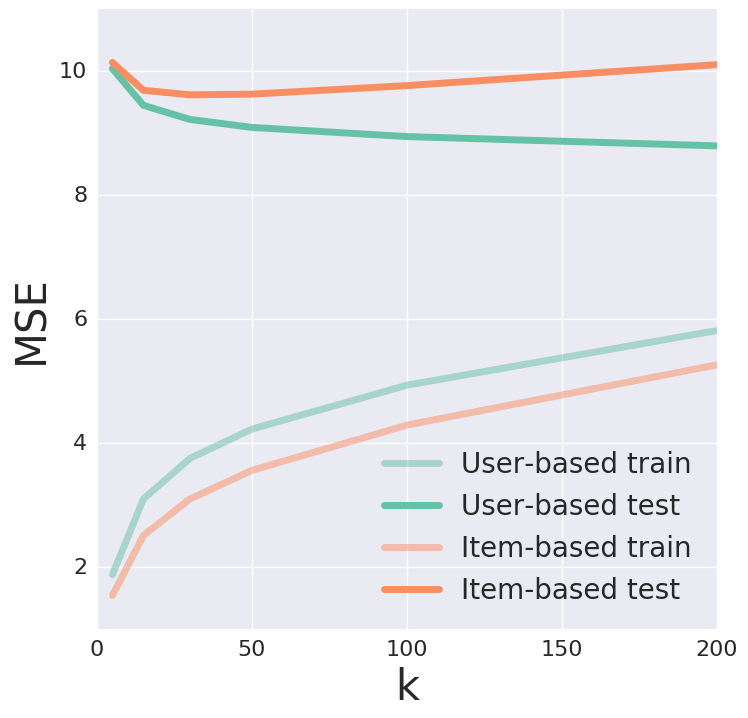

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

 计算无偏置下均方根误差MSE


In [33]:
def predict_nobias(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        pred = similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
        pred += user_bias[:, np.newaxis]
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        pred += item_bias[np.newaxis, :]
        
    return pred

In [36]:
user_pred = predict_nobias(train_data, user_similarity, kind='user')
print ('Bias-subtracted User-based CF MSE:'  + str(get_mse(user_pred, test_data)))

item_pred = predict_nobias(train_data, item_similarity, kind='item')
print ('Bias-subtracted Item-based CF MSE:'  + str(get_mse(item_pred, test_data)))

Bias-subtracted User-based CF MSE:9.5495943849
Bias-subtracted Item-based CF MSE:9.94685069999


In [ ]:
import requests
import json


In [ ]:
# response = requests.get('http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)')
# print (response.url.split('/')[-2])

In [ ]:
# # Get base url filepath structure. w185 corresponds to size of movie poster.
# headers = {'Accept': 'application/json'}
# payload = {'api_key': '这里填入你的API'} 
# response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
# response = json.loads(response.text)
# base_url = response['images']['base_url'] + 'w185'

# def get_poster(imdb_url, base_url):
#     # Get IMDB movie ID
#     response = requests.get(imdb_url)
#     movie_id = response.url.split('/')[-2]
    
#     # Query themoviedb.org API for movie poster path.
#     movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
#     headers = {'Accept': 'application/json'}
#     payload = {'api_key': '这里填入你的API'} 
#     response = requests.get(movie_url, params=payload, headers=headers)
#     try:
#         file_path = json.loads(response.text)['posters'][0]['file_path']
#     except:
#         # IMDB movie ID is sometimes no good. Need to get correct one.
#         movie_title = imdb_url.split('?')[-1].split('(')[0]
#         payload['query'] = movie_title
#         response = requests.get('http://api.themoviedb.org/3/search/movie', params=payload, headers=headers)
#         movie_id = json.loads(response.text)['results'][0]['id']
#         payload.pop('query', None)
#         movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
#         response = requests.get(movie_url, params=payload, headers=headers)
#         file_path = json.loads(response.text)['posters'][0]['file_path']
        
#     return base_url + file_path